# Toronto Neighborhood Segmentation and Cluster
Alif Sussardi

This week 3 project was carried out to segment and cluster neighborhood of Toronto with the data obtained from wikipedia page: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

The data from link above will be imported as a dataframe using pandas, and then wrangled. 

The dataframe will contains three columns: PostalCode, Borough and Neighborhood.
- Ignore borough that is Not assigned.
- Put borough name to the Neighborhood that is Not Assigned.
- Merge PostalCode with the same Neighborhood

### First of all, import all packages that will be needed for this project.

Note-- some packages may will be imported later on when relevant

In [166]:
#Pandas for dataframe analysis
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# tranform JSON file into a pandas dataframe
from pandas.io.json import json_normalize 

#Numpy for array operations
import numpy as np 

#json for handling with json data
import json 

# convert address into coordinate values
from geopy.geocoders import Nominatim

# library to handle requests
import requests 

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# KMeans from sklearn for clustering
from sklearn.cluster import KMeans

# to render map
import folium 

#beautiful soup library for importing html format
#!pip install beautifulsoup4    #to install bs4 package
from bs4 import BeautifulSoup

#package to process html and xml
import lxml

print('Libraries imported.')

Libraries imported.


## Get the data and wrangle and Add Coordinate

The data is imported from wikipedia https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

### Get the data using request library

In [167]:
#declare data source url
data_source = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

# download and parse the data from url
req = requests.get(data_source)
soup = BeautifulSoup(req.text, 'html.parser')
table = soup.find('table', attrs={'class':'wikitable sortable'})

### Get the rows

To get rows, header must be declared first

In [168]:
# Declare Headers from the table header key <th>
header = table.findAll('th')
for i, head in enumerate(header): 
    header[i]=str(header[i]).replace("<th>","").replace("</th>","").replace("\n","")

Get all rows

In [169]:
# get all the data in the table, it is identified with tr from table row, 

#declare the rows, this will return as list
rows = table.findAll('tr')

# the first row will be the one of the header, so get from the second row
rows = rows[1:len(rows)]

#get all rows
for i, row in enumerate(rows): 
    rows[i] = str(rows[i]).replace("\n</td></tr>","").replace("<tr>\n<td>","")
    

### Create New Dataframe from Rows

In [170]:
# Make dataframe from rows
df=pd.DataFrame(rows)

# assign header from df[0] split with the remnants of the html, assign it to 2 new columns 
df[header] = df[0].str.split("\n</td>\n<td>", expand = True) 

# Remove the original html column
df.drop(columns=[0],inplace=True)

# Rename PostalCode column to PostalCode
df.rename(columns = {'Postal Code':'PostalCode'}, inplace=True)

In [171]:
df.head()

,PostalCode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


### Dealing with "Not assigned" Value and duplicates

In [172]:
# delete rows with the Borough column has value of Not assigned
df = df.drop(df[df.Borough == "Not assigned"].index).reset_index(drop=True)

# Assign the value of Borough to the Neighbourhood when its Not assigned
df = df.replace(df[df.Neighbourhood == "Not assigned"], df.Borough)

# If there is an empty cell in Neighbourhood, fill it with Borough
df.Neighbourhood.fillna(df.Borough, inplace=True)

# Remove duplicates
df = df.drop_duplicates()


### Combine all Borough and Neighbourhood with same PostalCode

In [173]:
# combine multiple neighborhood
#index all unique postalcode
df_un = pd.DataFrame({'PostalCode':df.PostalCode.unique()})

#add new column name Borough, consist of Borough with same PostalCode
df_un['Borough'] = pd.DataFrame(list(set(df['Borough'].loc[df['PostalCode'] == x['PostalCode']])) for i, x in df_un.iterrows())

#same method, add new column name: Neighborhood, consists of Neighborhood with same PostalCode
df_un['Neighborhood'] = pd.DataFrame(list(set(df['Neighbourhood'].loc[df['PostalCode'] == x['PostalCode']])) for i, x in df_un.iterrows())

In [174]:
df_un.head(12)

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


### Get Geospatial data of Toronto

after the geostpatial data obtained. the geospatial data then added to the toronto dataframe.

In [175]:
# Use the geospatial data from Cocl
geo_url = 'https://cocl.us/Geospatial_data'
geo_data = pd.read_csv(geo_url)
geo_data.rename(columns = {'Postal Code': "PostalCode"}, inplace = True)

# To merge df_un and geo_data PostalCode must be assigned as index
df_un.set_index('PostalCode')
geo_data.set_index('PostalCode')

# Merge two data
df_toronto = pd.merge(df_un, geo_data)
df_toronto.shape

(103, 5)

In [176]:
df_toronto.head(12)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.667856,-79.532242
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
7,M3B,North York,Don Mills,43.745906,-79.352188
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


### Filter Borough Containing "Toronto"

I only want to cluster Borough that contains "Toronto" in their name.

In [177]:
# Create a mask, containing information whether row number has the word Toronto
mask = df['Borough'].str.contains('Toronto')

In [178]:
# Create new dataframe only_toronto
only_toronto = df_toronto[mask]
only_toronto.reset_index(drop=True, inplace=True)
only_toronto.head(5)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


### EXPLORE TORONTO

To explore toronto, first we have to define the user_agent, as shown below. 

In [179]:
address = 'Toronto, ON, Canada'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)

#declare latitude ang longitude of Toronto
latitude = location.latitude
longitude = location.longitude

print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [180]:
# create map of Toronto using latitude and longitude values from borough that contains Toronto
toronto_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(only_toronto['Latitude'], only_toronto['Longitude'], only_toronto['Borough'], only_toronto['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(toronto_map)  
    
toronto_map

Next, is to utilise Forsquare API to explore the neighborhood that has been mapped above.

### Define Forsquare Credentials and Version

In [181]:
CLIENT_ID = 'J3CMVHKAWSEY0XERG4LZAXGQXF3JS3YZHUICIJNX3K3UYOD0' # your Foursquare ID
CLIENT_SECRET = 'I2K5FYQT1NJTHBZP4XKWUY4OYTXMS02S4ODUUJVTBQ3KBRNA' # your Foursquare Secret
ACCESS_TOKEN = '4ALZXGOA4IKH5AZXI44FDFITI3JKEWLADWE34HCI3LL4KGI3' # your FourSquare Access Token
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: J3CMVHKAWSEY0XERG4LZAXGQXF3JS3YZHUICIJNX3K3UYOD0
CLIENT_SECRET:I2K5FYQT1NJTHBZP4XKWUY4OYTXMS02S4ODUUJVTBQ3KBRNA


### Lets explore the first neighborhood in the dataframe

The name of the neighborhood:

In [182]:
only_toronto.loc[0, 'Neighborhood']

'Regent Park, Harbourfront'

And the latitude and longitude:

In [183]:
neighborhood_latitude = only_toronto.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = only_toronto.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = only_toronto.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Regent Park, Harbourfront are 43.6542599, -79.3606359.


### Lets get 100 most popular venues in the Regent Park and Harbourfront within 300 m radius

In [193]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 300 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=J3CMVHKAWSEY0XERG4LZAXGQXF3JS3YZHUICIJNX3K3UYOD0&client_secret=I2K5FYQT1NJTHBZP4XKWUY4OYTXMS02S4ODUUJVTBQ3KBRNA&v=20180605&ll=43.6542599,-79.3606359&radius=300&limit=100'

Get the results from the url above: The results is JSON format.

In [194]:
results = requests.get(url).json()

I am borrowing get_category_type function from the previous week to get the type information in the results

In [195]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

The json then cleaned and turned into pandas dataframe

In [196]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

<ipython-input-196-561c05f0fdd1>:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  nearby_venues = json_normalize(venues) # flatten JSON


,name,categories,lat,lng
0,Roselle Desserts,Bakery,43.653447,-79.362017
1,Tandem Coffee,Coffee Shop,43.653559,-79.361809
2,Cooper Koo Family YMCA,Distribution Center,43.653249,-79.358008
3,Body Blitz Spa East,Spa,43.654735,-79.359874
4,Morning Glory Cafe,Breakfast Spot,43.653947,-79.361149


How many venues returned by Foursquare:

In [197]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

11 venues were returned by Foursquare.


## Explore Neighborhood in Toronto

#### we are not going to explore only the Regent Park region, but all Neighborhood in the only_toronto dataframe

I also borrw __getNearbyVenues__ function to simultaneously find the venues from the list of neighborhood in only_toronto  dataframe

In [198]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now write a code to run the function on each neighborhood in the __only_toronto__ dataframe:

In [199]:
toronto_venues = getNearbyVenues(names=only_toronto['Neighborhood'],
                                   latitudes=only_toronto['Latitude'],
                                   longitudes=only_toronto['Longitude']
                                  )

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North &amp; West, Forest Hill Road Park
High Park, The Junction South
North Toronto West,  Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airp

#### Check the size of the dataframe

In [201]:
print(toronto_venues.shape)
toronto_venues.head()

(1624, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,"Regent Park, Harbourfront",43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant


Lets check the number of venues returned from each neighborhood:

In [1]:
toronto_venues.groupby('Neighborhood').count()

NameError: name 'toronto_venues' is not defined

#### With the number of unique venues:

In [206]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 235 uniques categories.


### Analyse each neighborhood

In [207]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

The dataframe size:

In [208]:
toronto_onehot.shape

(1624, 235)

#### Now, group rows by the neighborhood name and taking the average of accurance of each column

In [209]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar
0,Berczy Park,0.000000,0.0,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.0,0.0,0.0,0.018182,0.000000,0.0,0.0,0.0,0.0000,0.0,0.0,0.018182,0.036364,0.0,0.000000,0.0,0.018182,0.018182,0.0,0.036364,0.0,0.0,0.018182,0.0000,0.000000,0.0000,0.0,0.018182,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.0000,0.018182,0.0,0.0,0.0,0.0,0.036364,0.0,0.0,0.0,0.000000,0.0,0.036364,0.090909,0.0,0.0,0.0,0.0,0.0,0.0,0.018182,0.000000,0.018182,0.000000,0.0,0.0,0.018182,0.0,0.0,0.0,0.0,0.018182,0.000000,0.0,0.018182,0.000000,0.0,0.0,0.0,0.000000,0.0,0.018182,0.0,0.0,0.0,0.0,0.000000,0.036364,0.0000,0.0,0.0,0.018182,0.0,0.0

#### Now check the shape of dataframe after grouping

In [210]:
toronto_grouped.shape

(39, 235)

#### And print neighborhoods with 5 most common venues

In [211]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
                venue  freq
0         Coffee Shop  0.09
1  Seafood Restaurant  0.04
2            Beer Bar  0.04
3         Cheese Shop  0.04
4          Restaurant  0.04


----Brockton, Parkdale Village, Exhibition Place----
            venue  freq
0            Café  0.13
1       Nightclub  0.09
2     Coffee Shop  0.09
3  Breakfast Spot  0.09
4   Grocery Store  0.04


----Business reply mail Processing Centre, South Central Letter Processing Plant Toronto----
                  venue  freq
0            Skate Park  0.06
1         Auto Workshop  0.06
2        Farmers Market  0.06
3  Fast Food Restaurant  0.06
4         Burrito Place  0.06


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
             venue  freq
0   Airport Lounge  0.12
1  Airport Service  0.12
2         Boutique  0.06
3            Plane  0.06
4    Boat or Ferry  0.06


----Central Bay Street----
                venue  freq
0         Coff

#### Lets put the list into a pandas dataframe

Lets Borrow a function to sort the veues in descending order:

In [212]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now lets make top 10 venues for each neighborhood

In [213]:
# declare number of venues
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Bakery,Seafood Restaurant,Farmers Market,Cheese Shop,Beer Bar,Restaurant,Greek Restaurant,Pub
1,"Brockton, Parkdale Village, Exhibition Place",Café,Coffee Shop,Breakfast Spot,Nightclub,Performing Arts Venue,Convenience Store,Bar,Bakery,Italian Restaurant,Stadium
2,"Business reply mail Processing Centre, South C...",Auto Workshop,Park,Fast Food Restaurant,Light Rail Station,Farmers Market,Recording Studio,Burrito Place,Pizza Place,Restaurant,Butcher
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Lounge,Airport Service,Coffee Shop,Harbor / Marina,Plane,Rental Car Location,Sculpture Garden,Boutique,Bar,Boat or Ferry
4,Central Bay Street,Coffee Shop,Café,Sandwich Place,Italian Restaurant,Salad Place,Department Store,Thai Restaurant,Japanese Restaurant,Burger Joint,Bubble Tea Shop


### It would be interesting to plot what venue is the most, second most and third most common in the region.

#### Import the relevant library

In [214]:
import matplotlib.pyplot as plt
import seaborn as sns

#### Make new dataframes, containing first, second and third most common venues

In [215]:
first = neighborhoods_venues_sorted['1st Most Common Venue'].value_counts().to_frame()
second = neighborhoods_venues_sorted['2nd Most Common Venue'].value_counts().to_frame()
third = neighborhoods_venues_sorted['3rd Most Common Venue'].value_counts().to_frame()

onetothree = pd.merge(first, second, how = 'outer', left_index=True, right_index=True)
onetothree = pd.merge(onetothree, third, how = 'outer', left_index=True, right_index=True)
onetothree.fillna(0, inplace=True)
onethreesorted = onetothree.sort_values('1st Most Common Venue', ascending=False)

#### Plot the most common venues

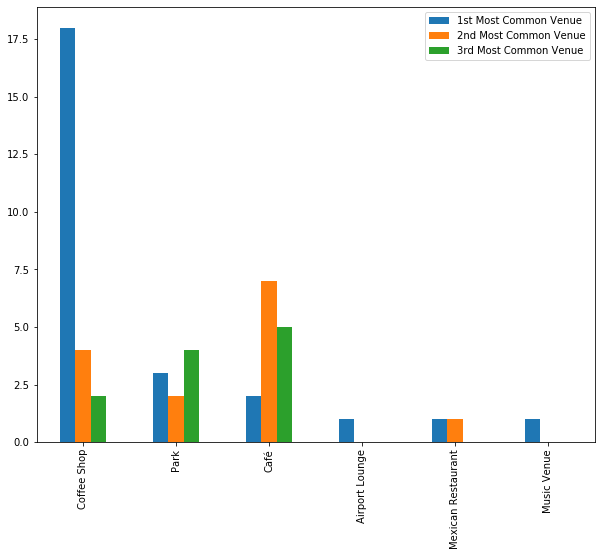

In [216]:
onethreesorted.head(6).plot(kind = 'bar', 
                           figsize = (10,8))

From the graph above, it is clear that the most common venue iw Coffe Shop, that means we wont need to worry about not having a coffee!

## Cluster Neighborhoods

Run k-means to cluster neighborhood into 3 clusters.

In [218]:
# set number of clusters
kclusters = 3

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Create new dataframe that include 10 most common venue and assign it to its neighborhood

In [219]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df_toronto

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')



# check the last columns!
toronto_merged.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,M4A,North York,Victoria Village,43.725882,-79.315572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0.0,Coffee Shop,Pub,Park,Bakery,Theater,Café,Breakfast Spot,Brewery,Spa,Farmers Market
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0.0,Coffee Shop,Yoga Studio,Café,Smoothie Shop,Beer Bar,Sandwich Place,Restaurant,Distribution Center,Diner,Portuguese Restaurant


Delete the neighborhood with out cluster numebr

In [220]:
toronto_merged.dropna(inplace=True)

Lets visualise the cluster!

In [221]:

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, boro, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Borough'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ', '+str(boro) +' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### List of the first cluster

In [222]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Downtown Toronto,0.0,Coffee Shop,Pub,Park,Bakery,Theater,Café,Breakfast Spot,Brewery,Spa,Farmers Market
4,Downtown Toronto,0.0,Coffee Shop,Yoga Studio,Café,Smoothie Shop,Beer Bar,Sandwich Place,Restaurant,Distribution Center,Diner,Portuguese Restaurant
9,Downtown Toronto,0.0,Clothing Store,Coffee Shop,Café,Japanese Restaurant,Cosmetics Shop,Bubble Tea Shop,Hotel,Lingerie Store,Ramen Restaurant,Italian Restaurant
15,Downtown Toronto,0.0,Coffee Shop,Café,Cocktail Bar,Restaurant,Beer Bar,American Restaurant,Gastropub,Clothing Store,Seafood Restaurant,Cosmetics Shop
19,East Toronto,0.0,Pub,Trail,Health Food Store,Dance Studio,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Distribution Center
20,Downtown Toronto,0.0,Coffee Shop,Cocktail Bar,Bakery,Seafood Restaurant,Farmers Market,Cheese Shop,Beer Bar,Restaurant,Greek Restaurant,Pub
24,Downtown Toronto,0.0,Coffee Shop,Café,Sandwich Place,Italian Restaurant,Salad Place,Department Store,Thai Restaurant,Japanese Restaurant,Burger Joint,Bubble Tea Shop
25,Downtown Toronto,0.0,Grocery Store,Café,Park,Athletics & Sports,Restaurant,Nightclub,Candy Store,Coffee Shop,Baby Store,Italian Restaurant
30,Downtown Toronto,0.0,Coffee Shop,Café,Gym,Restaurant,Hotel,Thai Restaurant,Bar,Clothing Store,Bookstore,Breakfast Spot
31,West Toronto,0.0,Pharmacy,Bakery,Park,Bank,Supermarket,Bar,Middle Eastern Restaurant,Café,Brewery,Grocery Store


As we can see the fist cluster mainly in the city, where Coffee Shop is the most common

### List of second cluster

In [223]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
61,Central Toronto,1.0,Park,Bus Line,Swim School,Wine Bar,Deli / Bodega,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run
68,Central Toronto,1.0,Sushi Restaurant,Park,Jewelry Store,Trail,Wine Bar,Distribution Center,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
83,Central Toronto,1.0,Trail,Playground,Wine Bar,Dance Studio,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Distribution Center
91,Downtown Toronto,1.0,Park,Trail,Playground,Wine Bar,Dance Studio,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Distribution Center


This cluster could be the cluster for outdoor activity and a sign of residential area

### List of third cluster

In [224]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
62,Central Toronto,2.0,Music Venue,Garden,Wine Bar,Deli / Bodega,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Distribution Center


Likely residential area where Music Venue is the most common!